In [136]:
# Import needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from data import find_property 
from exchange_rate import fetch_eur_exchange_rate

### DATA PREPROCESSING
In this section, I'm prepping the data to ensure it's ready for detailed analysis later on.

In [137]:
# Import apartments data fetched from Property24 and display the first few rows
find_property()
data = pd.read_csv('property.csv')
column_names = data.columns
data.head()

,Price,Bedrooms,Bathrooms,Size
0,ZMW2400000,3.0,2.5,80m²
1,ZMW5500000,2.0,NaN,1600m²
2,ZMW550000,1.0,1.0,57m²
3,ZMW22100000,NaN,NaN,4000m²
4,ZMW3000000,2.0,NaN,600m²


In [138]:
# Get the current exchange rate
exchange_rate = fetch_eur_exchange_rate()

# Convert 'Price' to numeric and change to €
data['Price'] = data['Price'].str.extract('(\d+)').astype(float)
data['Price'] = data['Price'] * float(exchange_rate)

# Removing outliers
# Calculate mean and standard deviation of 'Price'
mean_price = data['Price'].mean()
std_dev_price = data['Price'].std()

# Define a threshold based on standard deviations
threshold = 1 * std_dev_price

# Filter out values beyond the threshold
data = data[abs(data['Price'] - mean_price) <= threshold]

<class 'float'>


In [139]:
# Define a function to extract the size value in m²
def size_cleared(value):
    if isinstance(value, (float, int)):
        return float(value)
    elif 'm²' in value:
        return float(value.replace('m²', '').strip())
    elif 'acres' in value:
        acres = float(value.replace('acres', '').strip())
        return acres * 4046.86
    else:
        return np.nan

data['Size'] = data['Size'].apply(size_cleared)

# Removing outliers
# Calculate mean and standard deviation of 'Size'
mean_size = data['Size'].mean()
std_dev_size = data['Size'].std()

# Define a threshold based on standard deviations
threshold = 2 * std_dev_size

# Filter out values beyond the threshold
data = data[(np.isnan(data['Size'])) | (abs(data['Size'] - mean_size) <= threshold)]

In [140]:
# Remove outliers
# Calculate mean and standard deviation for 'Bathrooms' and 'Bedrooms'
mean_bathrooms = data['Bathrooms'].mean()
std_dev_bathrooms = data['Bathrooms'].std()

mean_bedrooms = data['Bedrooms'].mean()
std_dev_bedrooms = data['Bedrooms'].std()

# Define thresholds based on standard deviations
threshold_bathrooms = 2 * std_dev_bathrooms
threshold_bedrooms = 2 * std_dev_bedrooms

# Filter out outliers based on standard deviation thresholds
data = data[((np.isnan(data['Bathrooms'])) | (abs(data['Bathrooms'] - mean_bathrooms) <= threshold_bathrooms)) &
            ((np.isnan(data['Bedrooms'])) | (abs(data['Bedrooms'] - mean_bedrooms) <= threshold_bathrooms))]

In [141]:
# Show descriptive statistics for the dataset
data.describe()

,Price,Bedrooms,Bathrooms,Size
count,171.000000,151.000000,139.000000,68.000000
mean,131210.051150,2.503311,1.931655,1276.838885
std,151948.381982,0.651912,0.670824,1972.977686
min,297.715050,1.000000,1.000000,7.000000
25%,45532.890000,2.000000,1.750000,483.750000
50%,73553.130000,3.000000,2.000000,600.000000
75%,140101.200000,3.000000,2.000000,1228.500000
max,710313.084000,4.000000,4.000000,12140.580000


In [142]:
# Replace the NaN values in 'Bedrooms' and 'Bathrooms' with their respective mode
mode_bedrooms = data['Bedrooms'].mode()[0]
data['Bedrooms'] = data['Bedrooms'].fillna(mode_bedrooms)

mode_bathrooms = data['Bathrooms'].mode()[0]
data['Bathrooms'] = data['Bathrooms'].fillna(mode_bathrooms)

### DATA VISUALIZATION
In this section, I'll be visualizing the data to uncover patterns and insights for better understanding and analysis.

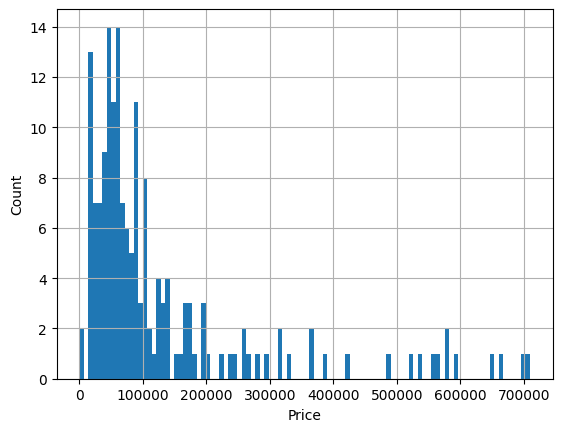

In [143]:
# Plot the histogram of apartment/house prices
data["Price"].hist(bins=100)
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

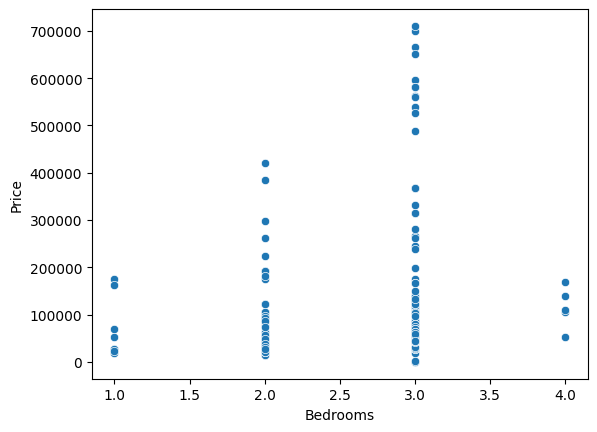

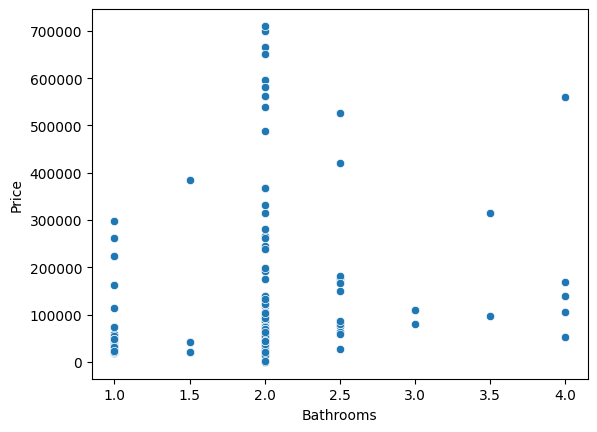

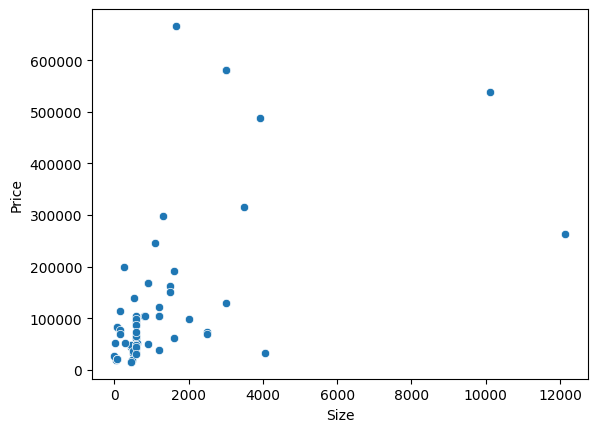

In [144]:
# Plot scatterplots of price against each independent variable
for i, col in enumerate(column_names[1:]):
    plt.figure(i)
    sns.scatterplot(data, x=str(col), y='Price')
# Note that the size variable has many NaN values

### FILLING MISSING SIZE VALUES
In this section, I handle missing values in the 'Size' column of our dataset, ensuring completeness and enabling further analysis (with more data).

In [145]:
# Extracting features and target for training data
X_train = data.dropna(subset=['Size']).drop('Size', axis=1).to_numpy()

y_train = data.dropna(subset=['Size'])['Size'].to_numpy()
y_train = y_train[:, None]

# Extracting features for prediction data
X_pred = data[data['Size'].isna()].drop('Size', axis=1).to_numpy()

C:\Users\tanja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


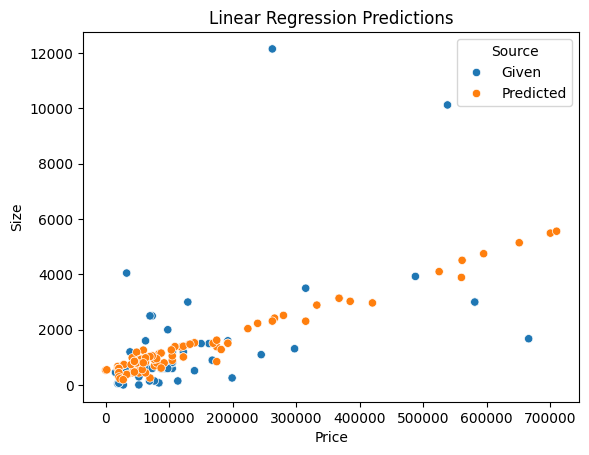

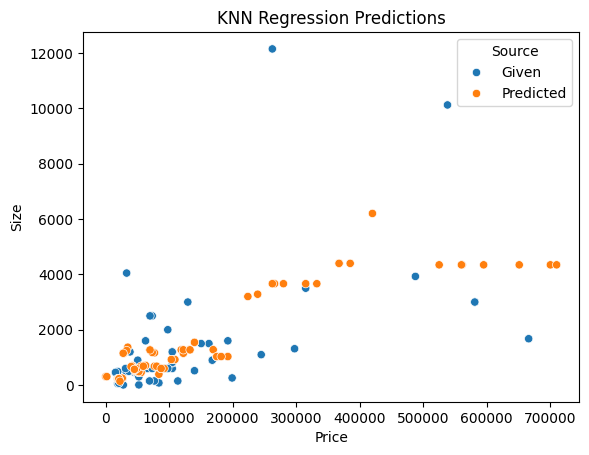

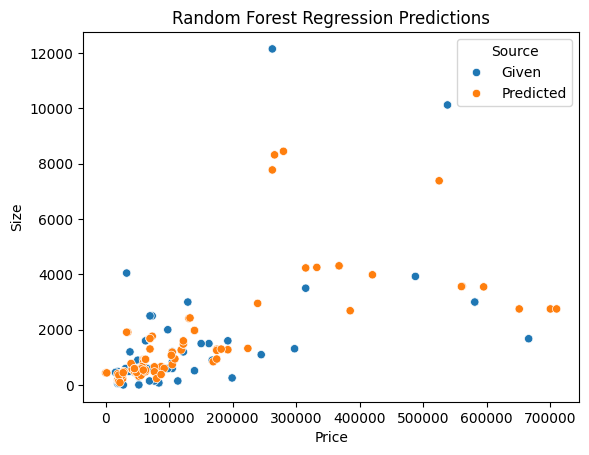

In [146]:
# Set random seed for reproducibility
np.random.seed(7)

# Models initialization
models = {
    'Linear Regression': LinearRegression(),
    'KNN Regression': KNeighborsRegressor(),
    'Random Forest Regression': RandomForestRegressor()
}

# Initialize an empty DataFrame to store predicted values for each model
predictions = pd.DataFrame(columns=list(models.keys()))

# Iterate through each model for training, prediction, and plotting
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_pred)
    
    # Store predicted values in the predictions DataFrame
    y_pred = pd.DataFrame(y_pred, columns=[column_names[-1]])
    predictions[model_name] = y_pred

    # Combine predictions with features
    data_pred = pd.concat([pd.DataFrame(X_pred, columns=column_names[:-1]), y_pred], axis=1)
    # Add 'Source' column to indicate predicted values
    data_pred['Source'] = 'Predicted'
    
    # Combine predicted and actual data for visualization
    data_combined = pd.concat([data.dropna(subset=['Size']).copy(), data_pred])
    data_combined.loc[:, 'Source'] = data_combined['Source'].fillna('Given')
    
    # Plot scatterplot for model predictions
    plt.figure()
    sns.scatterplot(data=data_combined, x='Price', y='Size', hue='Source')
    plt.title(f'{model_name} Predictions')
    
plt.show()


I decide to use the mean of all prediction types as the representative value for further analysis.

<Axes: xlabel='Size', ylabel='Price'>

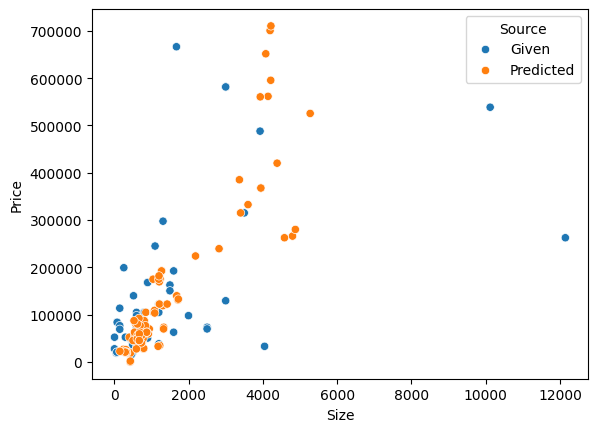

In [147]:
# Compute the mean of all different types of predictions
predictions['Size'] = predictions.mean(axis=1)

# Save the mean predicted value in a DataFrame
size = pd.DataFrame(predictions['Size'])

# Combine predictions with features and add a column 'Source' to indicate the predicted values
size_pred = pd.concat([pd.DataFrame(X_pred, columns=column_names[:-1]), size], axis=1)
size_pred['Source'] = 'Predicted'

# Combine predicted data with actual data
data_full = pd.concat([data.dropna(subset=['Size']).copy(), size_pred])
data_full.loc[:, 'Source'] = data_full['Source'].fillna('Given')

# Plot the sccater plot of price against size and use the 'Source' variable as the color indicator
sns.scatterplot(data_full, x='Size', y='Price', hue='Source')


### MODEL TRAINING FOR PRICE PREDICTION
In this section I train different models to predict the price of the apartment/house.

First I prepare different datasets to train the models on.

In [148]:
# Extracting the target value
y = data_full['Price'].to_numpy()

# Extracting the "raw" feature values
X = data_full.drop(['Price', 'Source'], axis=1).to_numpy()

# Feature values with dummy variables for the 'Bathrooms' and 'Bedrooms' columns
X_dummy = pd.get_dummies(data_full, columns = ['Bathrooms', 'Bedrooms']).drop(['Price', 'Source'], axis=1)
X_dummy = X_dummy.to_numpy()

# Feature values where the values of 'Size' column are standardized
X_stand = data_full.drop(['Price', 'Source'], axis=1)
X_stand['Size'] = (X_stand['Size'] - np.mean(X_stand['Size']))/(np.std(X_stand['Size']))
X_stand = X_stand.to_numpy()

# I create the following two datasets to eliminate the effect of multicollinearity
# The features are the number of bedrooms and bathrooms
X_rooms = data_full[['Bedrooms', 'Bathrooms']].to_numpy()

# The only feature is the size of the apartment/house
X_size = data_full['Size'].to_numpy()

Then I train and test multiple machine learning models (linear regression, KNN regression, random forest regression) using k-fold cross-validation with 5 splits. Shuffling the data before splitting helps to ensure the reliability of the model evaluations. K-fold cross-validation allows us to assess each model's performance more robustly by averaging over multiple train-test splits.

In [149]:
# Set random seed for reproducibility
np.random.seed(7)

# Initialize KFold object with 5 splits
kfold = KFold(n_splits=5, shuffle=True)

# Initialize lists to store errors for each model and each dataset
lr_errors = {'X': [], 'X_dummy': [], 'X_stand': [], 'X_rooms': [], 'X_size': []}
knn_errors = {'X': [], 'X_dummy': [], 'X_stand': [], 'X_rooms': [], 'X_size': []}
rf_errors = {'X': [], 'X_dummy': [], 'X_stand': [], 'X_rooms': [], 'X_size': []}

datasets = {'X': X, 'X_dummy': X_dummy, 'X_stand': X_stand, 'X_rooms': X_rooms, 'X_size': X_size}

# Loop through each dataset
for dataset_name, dataset in datasets.items():
    
    # Loop through each fold
    for i, (train_index, test_index) in enumerate(kfold.split(dataset)):
        # This if statement deals with the one-dimensionality of the X_size dataset
        if dataset_name == 'X_size':
            # I deal with the one-dimensional X_size dataset by adding an extra dimension
            # Split data into training and testing sets
            x_train = dataset[train_index]
            x_train = x_train[:, None] # Add dimension
            y_train = y[train_index]
            x_test = dataset[test_index]
            x_test = x_test[:, None] # Add dimension
            y_test = y[test_index]

        else:
            # Split data into training and testing sets
            x_train = dataset[train_index, :]
            y_train = y[train_index]
            x_test = dataset[test_index, :]
            y_test = y[test_index]
        
        # Linear Regression
        lr_model = LinearRegression().fit(x_train, y_train) # Training the model
        y_pred_lr = lr_model.predict(x_test) # Predicting values
        lr_error = np.sqrt(mean_squared_error(y_test, y_pred_lr)) # Computing the RMSE
        lr_errors[dataset_name].append(lr_error)
    
        # K-Nearest Neighbors Regression
        knn_model = KNeighborsRegressor().fit(x_train, y_train) # Training the model
        y_pred_knn = knn_model.predict(x_test) # Predicting values
        knn_error = np.sqrt(mean_squared_error(y_test, y_pred_knn)) # Computing the RMSE
        knn_errors[dataset_name].append(knn_error)
    
        # Random Forest Regression
        rf_model = RandomForestRegressor().fit(x_train, y_train) # Training the model
        y_pred_rf = rf_model.predict(x_test) # Predicting values
        rf_error = np.sqrt(mean_squared_error(y_test, y_pred_rf)) # Computing the RMSE
        rf_errors[dataset_name].append(rf_error)

# Print mean RMSE for each model and each dataset
for dataset_name in datasets.keys():
    print(f"Dataset: {dataset_name}")
    print(f"Mean RMSE Linear Regression ({dataset_name}): {np.mean(lr_errors[dataset_name])}")
    print(f"Mean RMSE KNN Regression ({dataset_name}): {np.mean(knn_errors[dataset_name])}")
    print(f"Mean RMSE Random Forest Regression ({dataset_name}): {np.mean(rf_errors[dataset_name])}")


Dataset: X
Mean RMSE Linear Regression (X): 109584.73134606439
Mean RMSE KNN Regression (X): 94275.29225353252
Mean RMSE Random Forest Regression (X): 87377.16141565354
Dataset: X_dummy
Mean RMSE Linear Regression (X_dummy): 117804.85044248015
Mean RMSE KNN Regression (X_dummy): 93908.53369855044
Mean RMSE Random Forest Regression (X_dummy): 95214.24890551015
Dataset: X_stand
Mean RMSE Linear Regression (X_stand): 107349.22510250317
Mean RMSE KNN Regression (X_stand): 94975.38990448526
Mean RMSE Random Forest Regression (X_stand): 85611.22116086852
Dataset: X_rooms
Mean RMSE Linear Regression (X_rooms): 147634.55599488897
Mean RMSE KNN Regression (X_rooms): 160939.8093807128
Mean RMSE Random Forest Regression (X_rooms): 151172.89577515432
Dataset: X_size
Mean RMSE Linear Regression (X_size): 106854.44011837171
Mean RMSE KNN Regression (X_size): 98112.25437457886
Mean RMSE Random Forest Regression (X_size): 95344.48053976125


Based on the mean RMSE values obtained from our analysis, we observe that all models across different datasets exhibit higher errors that desired. While the small size of our dataset may contribute to these results, further analysis  is essential to  gain a deeper understanding of each model's performance. Additional investigation could involve exploring feature importance, optimizing model hyperparameters, and potentially gathering more data to improve model generalization. These insights would be crucial in refining our predictive models for more accurate outcomes.
